# Project Topic 7

Authors: 
* Philipp Bonny (3761754)
* Benjamin Jung (3761649)
* Peter Klein (3761266)

## Data

The data for this project comes from New York Stock Exchange. The dataset was originally released
on Kaggle and, among other information, contains several years of daily stock prices for S&P 500
companies. The dataset is available from Moodle. For more detailed information about it, please
refer to its original description on Kaggle.

## Goal

The goal of this project is to predict the price of a stock for the next day, one week into the future, or one month into the future. This is a problem for which many traditional time-series analysis methods
exist (e.g., exponential smoothing), but which can also be addressed using recurrent neural
networks (e.g., LSTMs or GRUs).

## Ideas and Suggestions

* First, you need to familiarize yourself with the dataset and make sure that you understand the
different values in it and its particularities.

* Second, you should identify suitable baseline methods. These include traditional time-series
analysis methods (e.g., exponential smoothing and time-series decomposition). Note that you
do not have to implement those yourselves, but you can rely on existing implementations.
Also, consider having a look at Prophet as a general-purpose time-series prediction library
developed at facebook.

* Third, you should think about your own approach(es). One idea is to apply a form of recurrent
neural network (e.g., LSTM or GRU) to a time series in isolation, viewing it as a sequence of
numerical values. As a variant, you may consider taking additional information (e.g., the time
series belonging to other stocks) into account. The goal should always be to predict the price
of an individual stock, but you can vary how much additional information you consider.

* For the evaluation, you should compare the different approaches in terms of a suitable quality
measure (e.g., mean absolute error), consider different time periods, and vary how much historical data is taken into account.

## In this project
We will use the metric of mean sqared error to compare different approaches. 

* Simple Exponential Smoothing (SES)
* Facebook Prophet
* 


# Import Libraries

In [94]:
import pandas as pd

# we need to use numpy=1.19 to be compatible with tensorflow version
import numpy as np

# Plot Graphs
import matplotlib.pyplot as plt

# Calculate Dates
import datetime
import matplotlib.dates as mdates

# We use the sklearn lib to split the data into test/train data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Simple Exponential Smoothing (SES)
from statsmodels.tsa.api import SimpleExpSmoothing 

# Facebook Prophet
import plotly.graph_objects as go
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

# LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Configurations
ticker_name defines the name of the stock that should be trained and predicted on 

In [95]:
ticker_name = 'AAPL'

# Predefined Functions


In [96]:
def plot_graph(title, actual_date_df, actual_value_df):
    fig = plt.figure(figsize = (10,6))
    ax1 = fig.add_axes([0,0,1,1])
    ax1.set_title(title)

    ax1.plot(actual_date_df, actual_value_df, color='green', label='Actual')

    ax1.set_ylabel('Price')
    ax1.set_xlabel('Year')
    plt.legend()
    plt.show()

In [97]:
def plot_comparison_graph(title, actual_date_df, actual_value_df, predicted_date_df, predicted_value_df):
    fig = plt.figure(figsize = (10,6))
    ax1 = fig.add_axes([0,0,1,1])
    ax1.set_title(title)

    ax1.plot(actual_date_df, actual_value_df, color='green', label='Actual')
    ax1.plot(predicted_date_df,predicted_value_df, color='red', label='Predicted')

    ax1.set_ylabel('Price')
    ax1.set_xlabel('Year')
    plt.legend()
    plt.show()
    
def predict_prophet(prophet_data, days_to_predict):
    # Grap stock data to predict a month in the future
    train = prophet_data.drop(prophet_data.index[-days_to_predict:])
    init_test = prophet_data[-days_to_predict:]

    # Future defines the days/dates that will be predicted
    future = pd.DataFrame(init_test['ds'])

    # Start training the model with the testdata
    model = Prophet(daily_seasonality=False)
    model.fit(train)

    # make a prediction with the testdata for the last 31 days of data we have
    prophet_prediction = model.predict(future)
    return init_test, prophet_prediction

# Read Stock Data

First, we will read the existing stock prices of the S&P500 index from the csv file into a dataframe. We will use the adjusted price history. This takes into account dividends, stock splits and other factors that may have affected the price.

In [98]:
# Read complete csv file of stocks
sp500 = pd.read_csv('data/prices-split-adjusted.csv') 

# Filter dataframe by ticker_name
stock_df = sp500[sp500['symbol'] == ticker_name].copy(deep=False)

# Convert Date to panda DateTime
stock_df['date'] = pd.to_datetime(stock_df['date'], format = '%Y-%m-%d')

stock_df

,date,symbol,open,close,low,high,volume
254,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
721,2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
1189,2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
1657,2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2125,2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0
...,...,...,...,...,...,...,...
848767,2016-12-23,AAPL,115.589996,116.519997,115.589996,116.519997,14249500.0
849267,2016-12-27,AAPL,116.519997,117.260002,116.489998,117.800003,18296900.0
849767,2016-12-28,AAPL,117.519997,116.760002,116.199997,118.019997,20905900.0
850267,2016-12-29,AAPL,116.449997,116.730003,116.400002,117.110001,15039500.0


In [99]:
# We prepare the dataframe so we can use it for training
# therefore we select the Date and Closing Price
stock_df_date_close = stock_df[["date", "close"]]

stock_df_date_close

,date,close
254,2010-01-04,30.572857
721,2010-01-05,30.625713
1189,2010-01-06,30.138571
1657,2010-01-07,30.082857
2125,2010-01-08,30.282858
...,...,...
848767,2016-12-23,116.519997
849267,2016-12-27,117.260002
849767,2016-12-28,116.760002
850267,2016-12-29,116.730003


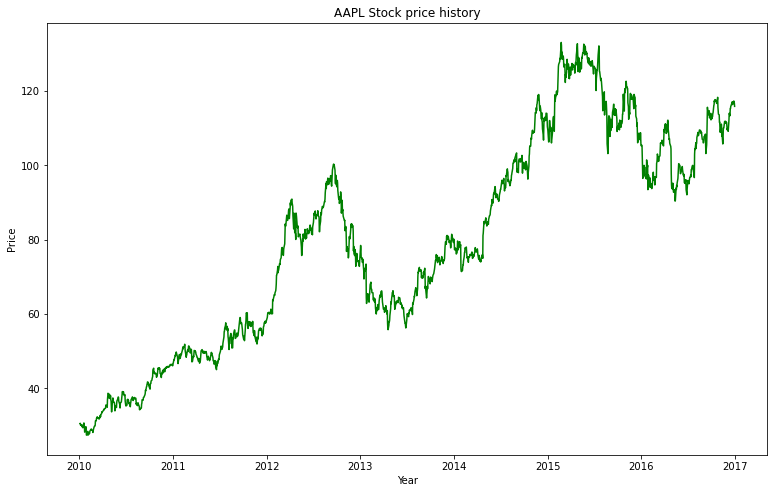

In [100]:
# Print History Stock prices
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_axes([0,0,1,1])
ax1.set_title(ticker_name + ' Stock price history')

ax1.plot(stock_df['date'],
         stock_df['close'],
         color='green')

ax1.set_ylabel('Price')
ax1.set_xlabel('Year')

plt.show()

# Simple Exponential Smoothing (SES)

TODO: Erklärung SES -> https://analyticsindiamag.com/hands-on-guide-to-time-series-analysis-using-simple-exponential-smoothing-in-python/
Definitionen?: https://sailajakarra.medium.com/time-series-analysis-using-python-and-pandas-49b806d2acf3


Also 2 Ansätze einmal alpha manuell und einmal vom system bestimmt
Wir prüfen hier 31 Tage in die zukunft
Hierfür mussten wir die fehlenden daten im datensatz erweitern
der graph zeigt beide vorhersagen des models

In [101]:
ses_data = stock_df_date_close.copy(deep=False)
ses_data.columns = ['ds','y']

ses_data_fitted = pd.Series(ses_data['y'].values, ses_data['ds'].values)

# Fill missing dates for SES (weekends while stock market is closed)
ses_data_fitted = ses_data_fitted.resample('D').ffill()

# We need to set the index frequency
ses_data_fitted.index = pd.DatetimeIndex(ses_data_fitted.index).to_period('D')

# Split the data so we compare the prediction against the actual value
# Grap stock data to predict a month in the future
ses_train = ses_data_fitted.drop(ses_data_fitted.index[-31:])
ses_test = ses_data_fitted[-31:]

D:\Software\anaconda3\envs\data-science\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation

D:\Software\anaconda3\envs\data-science\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning:

After 0.13 initialization must be handled at model creation



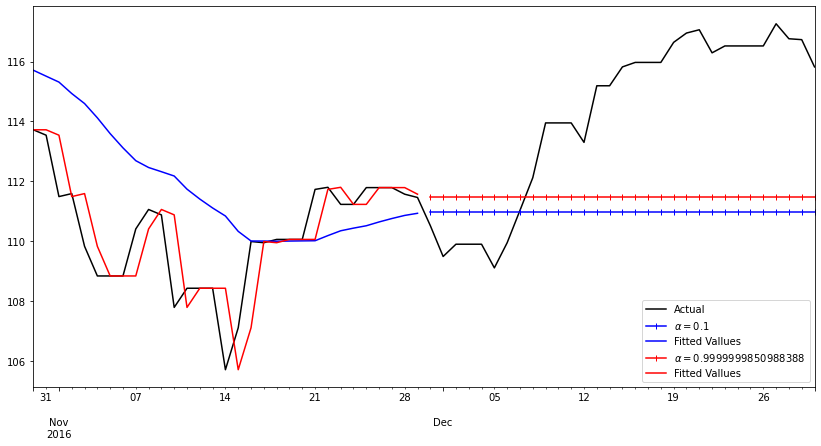

MSE for Prediction 1 with α=0.1 is: 18.102
MSE for Prediction 2 with α=0.9999999850988388 is: 15.255


In [102]:
ses_data_fitted[-62:].plot(color='black', legend=True, figsize=(14, 7), label="Actual") 
    
ses_fit_1 = SimpleExpSmoothing(ses_train).fit(smoothing_level=0.1,optimized=False)
predict_fit_1 = ses_fit_1.predict(ses_test.index.min(), ses_test.index.max()).rename(r'$\alpha={}$'.format(0.1))

# specific smoothing level
predict_fit_1.plot(marker="|",  color='blue', legend=True)
ses_fit_1.fittedvalues[-31:].plot(color='blue', legend=True, label="Fitted Vallues")

## auto optimization
ses_fit_2 = SimpleExpSmoothing(ses_train).fit()
predict_fit_2 = ses_fit_2.predict(ses_test.index.min(), ses_test.index.max()).rename(r'$\alpha=%s$'%ses_fit_2.model.params['smoothing_level'])

# plot
predict_fit_2.plot(marker="|", color='red', legend=True)
ses_fit_2.fittedvalues[-31:].plot(color='red', legend=True, label="Fitted Vallues")
     
plt.show()

#mse1 = ((predict_fit_1 - ses_test) ** 2).mean()
#print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(0.2,round(np.sqrt(mse1), 2)))

mse = mean_squared_error(ses_test.values, predict_fit_1.values)
print('MSE for Prediction 1 with \u03B1=0.1 is: %.3f' % mse)

mse2 = mean_squared_error(ses_test.values, predict_fit_2.values)
print('MSE for Prediction 2 with \u03B1=%s is: %.3f' % (ses_fit_2.model.params['smoothing_level'] , mse2))

# Facebook Prophet


In [103]:
# We need to rename the columns in order for Prophet to understand the data
prophet_data = stock_df_date_close.copy(deep=False)
prophet_data.columns = ['ds','y']

train, init_test = train_test_split(prophet_data, test_size=0.1, shuffle = False)

# Select only the dates for the test-set
test = pd.DataFrame(init_test['ds'])

# Start training the model with the testdata
model = Prophet(daily_seasonality=False)
model.fit(train)

# make a prediction with the testdata
prophet_prediction = model.predict(test)

In [104]:
plot_plotly(model, prophet_prediction)

This plot shows a trend estimate of the prophet model. If we compare this graph to the real price history of the underlying stock we can see that the actual value did not decrease as much as the model predicted. It followed a downwards trend while the actual stock price stagnated and did not decrase like forecasted. To analyse the prediction we will focus on a prediction of 31 days in the next example. Here we will calculate the MEA and plot the difference between the actual and dorcasted stock chart for this specific timeframe.


MSE: 178.044


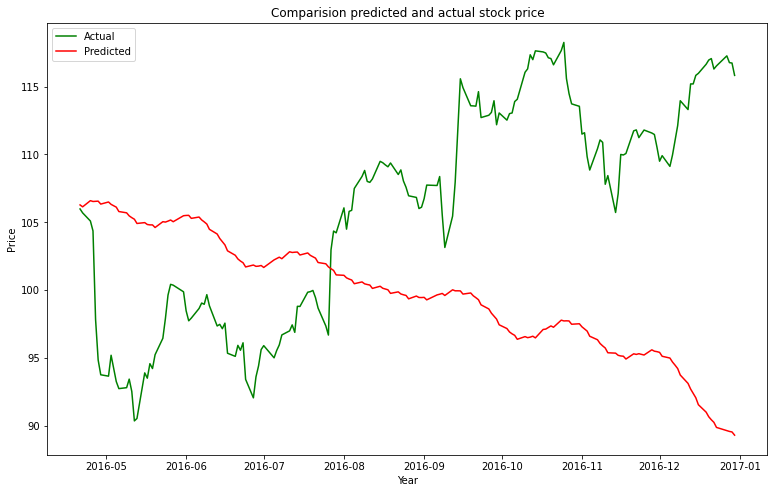

In [105]:
actual_data, prediction_data = predict_prophet(prophet_data, 177)

# calc MAE expected and predicted values
mse = mean_squared_error(actual_data['y'], prediction_data['yhat'])
print('MSE: %.3f' % mse)

plot_comparison_graph("Comparision predicted and actual stock price",
                      actual_data['ds'], 
                      actual_data['y'],
                      prediction_data['ds'],
                      prediction_data['yhat']
                     )

MSE: 280.178


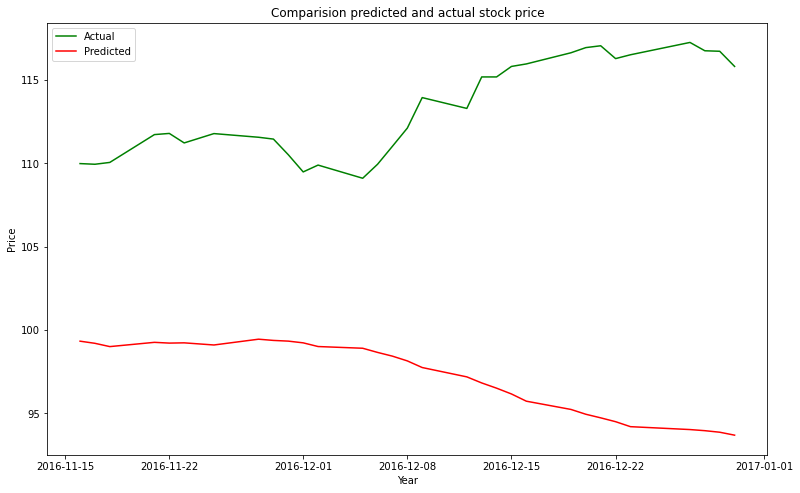

In [119]:
actual_data, prediction_data = predict_prophet(prophet_data, 31)

# calc MAE expected and predicted values
mse = mean_squared_error(actual_data['y'], prediction_data['yhat'])
print('MSE: %.3f' % mse)

plot_comparison_graph("Comparision predicted and actual stock price",
                      actual_data['ds'], 
                      actual_data['y'],
                      prediction_data['ds'],
                      prediction_data['yhat']
                     )

# Long short-term memory (LSTM)
TODO: Description

### Prepare the data

In [107]:
# Split the data into training and test and extract the close columns values
lstm_train = stock_df_date_close.drop(stock_df_date_close.index[-31:])
lstm_test = stock_df_date_close[-31:]

lstm_training_data = lstm_train.iloc[:, 1:2].values
print("====> LSTM Training Data\n")
print(lstm_training_data)

====> LSTM Training Data

[[ 30.57285686]
 [ 30.62571329]
 [ 30.13857071]
 ...
 [108.43      ]
 [105.709999  ]
 [107.110001  ]]


In [124]:
# Scale the values with MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
lstm_training_data_scaled = scaler.fit_transform(lstm_training_data)

# Prepare the data to be trained
# We will use a 60 timesteps/1 output model and fit our data
ts = 60
ds_length = len(lstm_training_data_scaled)
x = []
y = []

# We loop trough our dataset depending on our timesteps and assign the data to the x and y array
for i in range(ts, ds_length):
    x.append(lstm_training_data_scaled[i-ts:i, 0])
    y.append(lstm_training_data_scaled[i, 0])
    
# Convert the array to a numpy array for better access and manupulation of its data
x = np.array(x)
y = np.array(y)

# Reshaping the arrays to make sure that the data fit into the desired layer
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

### Layer setup

In [109]:
# Setup the RNN and assign the layer
seq = Sequential()

# 1 Layer
seq.add(LSTM(units=50, return_sequences=True, input_shape = (x.shape[1],1)))
seq.add(Dropout(0.2))

# 2 Layer
seq.add(LSTM(units=50, return_sequences=True))
seq.add(Dropout(0.2))

# 3 Layer
seq.add(LSTM(units=50, return_sequences=True))
seq.add(Dropout(0.2))

# 4 Layer
seq.add(LSTM(units=50))
seq.add(Dropout(0.2))

# Output Layer
seq.add(Dense(units = 1))

### Compile and Train LSTM
Use adam as our optimizer that can handle a lot of data and calculate the losses as MSE

In [110]:
# Compile
seq.compile(optimizer="adam", loss="mean_squared_error")

# Fitting the neural network to the training set
seq.fit(x,y,epochs=100,batch_size=32)

Epoch 1/100
53/53 [==============================] - 2s 42ms/step - loss: 0.0351
Epoch 2/100
53/53 [==============================] - 2s 41ms/step - loss: 0.0054
Epoch 3/100
53/53 [==============================] - 2s 41ms/step - loss: 0.0046
Epoch 4/100
53/53 [==============================] - 2s 41ms/step - loss: 0.0045
Epoch 5/100
53/53 [==============================] - 2s 40ms/step - loss: 0.0044
Epoch 6/100
53/53 [==============================] - 2s 40ms/step - loss: 0.0046
Epoch 7/100
53/53 [==============================] - 2s 40ms/step - loss: 0.0040
Epoch 8/100
53/53 [==============================] - 2s 40ms/step - loss: 0.0041
Epoch 9/100
53/53 [==============================] - 2s 39ms/step - loss: 0.0039
Epoch 10/100
53/53 [==============================] - 2s 40ms/step - loss: 0.0036
Epoch 11/100
53/53 [==============================] - 2s 40ms/step - loss: 0.0035
Epoch 12/100
53/53 [==============================] - 2s 40ms/step - loss: 0.0034
Epoch 13/100
53/53 [=====

53/53 [==============================] - 2s 39ms/step - loss: 9.6953e-04


### Predict and Compare with actual data

MSE: 1.577


ValueError: x and y must have same first dimension, but have shapes (31,) and (1762,)

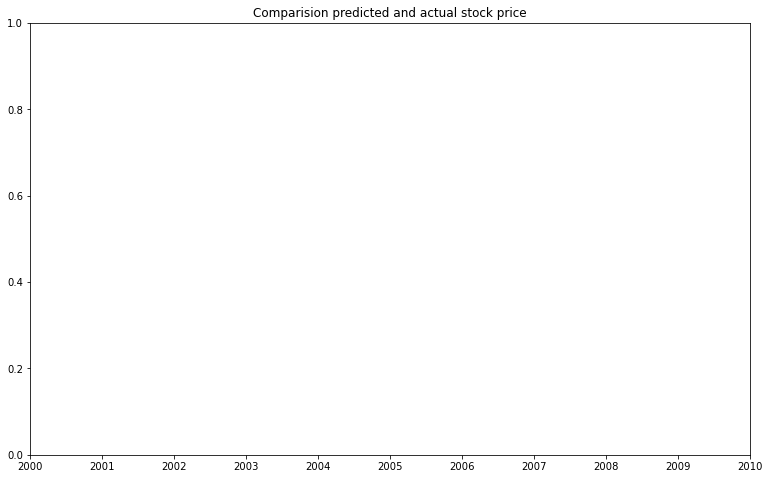

In [133]:
# Combine the train and testdata
actual_data = lstm_test.iloc[:, 1:2].values
combined_data = pd.concat((lstm_train['close'], lstm_test['close']), axis = 0)

# We need to create a dataset to predict future stock prices
predict_values = combined_data[len(combined_data) - len(lstm_test) - ts:].values
predict_values = predict_values.reshape(-1,1)
predict_values = scaler.transform(predict_values)

# create a array to predict the future
x_prediction = []

for i in range(ts, 91):
    x_prediction.append(predict_values[i-ts:i, 0])

# Convert the array to a numpy array for better access and manupulation of its data
x_prediction = np.array(x_prediction)

# Reshaping the arrays to make sure that the data fit into the desired layer
x_prediction = np.reshape(x_prediction, (x_prediction.shape[0], x_prediction.shape[1], 1))

# Predict stock price
predicted_data = seq.predict(x_prediction)
# Revert the transformed data
predicted_data = scaler.inverse_transform(predicted_data)


# calc MAE expected and predicted values
mse = mean_squared_error(actual_data, predicted_data)
print('MSE: %.3f' % mse)

plot_comparison_graph("Comparision predicted and actual stock price",
                      lstm_test["date"], 
                      stock_df['close'],
                      lstm_test["date"],
                      predicted_data
                     )


#plt.plot(lstm_test["date"],actual_data, color="black", label="Actual")
#plt.plot(lstm_test["date"],predicted_data, color="orange", label="Predicted")
#plt.title("Comparision predicted and actual stock price")
#plt.xlabel("Time")
#plt.ylabel("Stock Price $")
#plt.legend()
#plt.show()